# 4. Signal Generation

This notebook implements the Signal Layer of the pipeline.
We generate two types of signals:
1. **Time-Series Momentum (TSMOM)**: Trend following signals based on past 3, 6, and 12-month returns.
2. **Sleeve-Neutral Carry**: Carry signals normalized (z-scored) within their asset class (sleeve).

The resulting signals are added to the master dataset and saved.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Add src to path
sys.path.append('../')
from src.signals import calculate_tsmom_signal, calculate_sleeve_neutral_carry

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Data

In [2]:
DATA_PATH = '../data/processed/master_dataset_with_carry.parquet'
df = pd.read_parquet(DATA_PATH)
print(f"Loaded data with {len(df)} rows and columns: {df.columns.tolist()}")
display(df.head())

Loaded data with 606566 rows and columns: ['date', 'raw_symbol', 'expiration', 'open', 'high', 'low', 'close', 'volume', 'currency', 'instrument_id', 'root', 'month_code', 'year_code', 'parent', 'asset_class', 'region', 'days_to_expiry', 'is_front', 'is_next', 'return', 'carry']


,date,raw_symbol,expiration,open,high,low,close,volume,currency,instrument_id,...,month_code,year_code,parent,asset_class,region,days_to_expiry,is_front,is_next,return,carry
0,2020-05-14,NGZ27,2027-11-26 19:30:00+00:00,2.575,2.575,2.575,2.575,10,USD,11,...,Z,27,NG.FUT,Commodity,US,2752,False,False,NaN,-1.235979
1,2021-04-26,NGZ27,2027-11-26 19:30:00+00:00,2.875,2.875,2.875,2.875,8,USD,11,...,Z,27,NG.FUT,Commodity,US,2405,False,False,0.116505,-0.229489
2,2022-09-14,NGZ27,2027-11-26 19:30:00+00:00,5.340,5.340,5.340,5.340,4,USD,11,...,Z,27,NG.FUT,Commodity,US,1899,False,False,0.857391,-0.055046
3,2023-01-27,NGZ27,2027-11-26 19:30:00+00:00,4.940,4.940,4.940,4.940,4,USD,11,...,Z,27,NG.FUT,Commodity,US,1764,False,False,-0.074906,-0.099887
4,2023-07-25,NGZ27,2027-11-26 19:30:00+00:00,4.480,4.480,4.480,4.480,1,USD,11,...,Z,27,NG.FUT,Commodity,US,1585,False,False,-0.093117,-0.496183


## 2. TSMOM Signals
We construct a cumulative return index from the roll-adjusted returns to calculate momentum.
$$ R_{i,t}(k) = \frac{P_{i,t}}{P_{i,t-k}} - 1 $$
Signal = sign(R)

In [3]:
# Pivot returns to wide format (date x root)
# Filter for front contracts only to get continuous series
front_df = df[df['is_front']]
returns_wide = front_df.pivot(index='date', columns='root', values='return')

# Construct Price Index (Cumulative Product of 1+r)
# Fill NaNs with 0 for cumprod, then replace back if needed, or just handle NaNs.
# We assume 0 return if data is missing for a day in the wide matrix to keep index continuous.
price_index = (1 + returns_wide.fillna(0)).cumprod()

print("Price Index constructed.")
price_index.iloc[-5:, :5]

Price Index constructed.


root,6A,6B,6C,6E,6J
date,,,,,
2024-12-26,0.736052,0.747508,0.811470,0.709365,0.587606
2024-12-27,0.734516,0.750612,0.810068,0.709637,0.587282
2024-12-29,0.735520,0.750612,0.810708,0.710045,0.586914
2024-12-30,0.735993,0.748881,0.815095,0.708140,0.590477
2024-12-31,0.731851,0.746792,0.813983,0.704773,0.588997


In [4]:
tsmom_signals = {}
lookbacks = [3, 6, 12]

for k in lookbacks:
    print(f"Calculating TSMOM-{k}m...")
    sig = calculate_tsmom_signal(price_index, k)
    # Stack to long format to join back
    # sig is wide (date x root)
    sig_long = sig.stack().rename(f'tsmom_{k}m')
    tsmom_signals[k] = sig_long

print("TSMOM calculation complete.")

Calculating TSMOM-3m...
Calculating TSMOM-6m...
Calculating TSMOM-12m...
TSMOM calculation complete.


## 3. Sleeve-Neutral Carry Signal
Normalize carry within each asset class (sleeve) for each date.
$$ z = \frac{x - \mu_{sleeve}}{\sigma_{sleeve}} $$

In [5]:
# Prepare inputs
# Meta info for sleeves
meta = df[['root', 'asset_class']].drop_duplicates()

# Carry data indexed by date, root
# Ensure we have unique date-root pairs (should be true for master dataset)
carry_df = df[df['is_front']].set_index(['date', 'root'])[['carry']]

print("Calculating Sleeve-Neutral Carry Z-Scores...")
carry_z = calculate_sleeve_neutral_carry(carry_df, meta)
carry_z.name = 'carry_z'

print("Carry Z-Score calculation complete.")
display(carry_z.head())

2025-12-04 05:23:28,863 - INFO - Calculating Sleeve-Neutral Carry Signal...


Calculating Sleeve-Neutral Carry Z-Scores...
Carry Z-Score calculation complete.


date        root
2022-09-27  6C      0.665827
2022-10-10  6C      1.269794
2022-10-14  6C      1.290393
2022-10-17  6C      1.198281
2022-10-18  6C      1.163000
Name: carry_z, dtype: float64

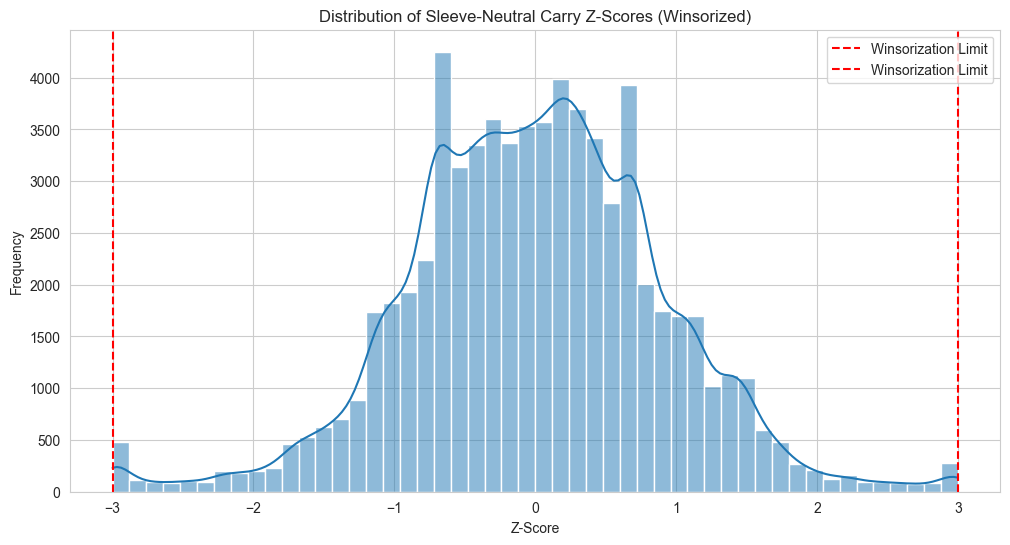

Carry Z-Score Range: -3.00 to 3.00


In [6]:
# Visualize Carry Z-Score Distribution (Winsorized)
plt.figure(figsize=(12, 6))
sns.histplot(carry_z, bins=50, kde=True)
plt.title('Distribution of Sleeve-Neutral Carry Z-Scores (Winsorized)')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.axvline(x=-3, color='r', linestyle='--', label='Winsorization Limit')
plt.axvline(x=3, color='r', linestyle='--', label='Winsorization Limit')
plt.legend()
plt.show()

print(f"Carry Z-Score Range: {carry_z.min():.2f} to {carry_z.max():.2f}")

## 4. Combine and Save
Merge all signals back into the master dataset.

In [7]:
# Set index on df for joining
df_signals = df.set_index(['date', 'root'])

# Join TSMOM
for k, sig in tsmom_signals.items():
    df_signals = df_signals.join(sig, how='left')

# Join Carry Z
df_signals = df_signals.join(carry_z, how='left')

# Reset index
df_signals = df_signals.reset_index()

print("Signals merged. New columns:", df_signals.columns.tolist())
display(df_signals.head())

Signals merged. New columns: ['date', 'root', 'raw_symbol', 'expiration', 'open', 'high', 'low', 'close', 'volume', 'currency', 'instrument_id', 'month_code', 'year_code', 'parent', 'asset_class', 'region', 'days_to_expiry', 'is_front', 'is_next', 'return', 'carry', 'tsmom_3m', 'tsmom_6m', 'tsmom_12m', 'carry_z']


,date,root,raw_symbol,expiration,open,high,low,close,volume,currency,...,region,days_to_expiry,is_front,is_next,return,carry,tsmom_3m,tsmom_6m,tsmom_12m,carry_z
0,2020-05-14,NG,NGZ27,2027-11-26 19:30:00+00:00,2.575,2.575,2.575,2.575,10,USD,...,US,2752,False,False,NaN,-1.235979,-1.0,-1.0,-1.0,-2.991764
1,2021-04-26,NG,NGZ27,2027-11-26 19:30:00+00:00,2.875,2.875,2.875,2.875,8,USD,...,US,2405,False,False,0.116505,-0.229489,-1.0,-1.0,1.0,-1.703463
2,2022-09-14,NG,NGZ27,2027-11-26 19:30:00+00:00,5.340,5.340,5.340,5.340,4,USD,...,US,1899,False,False,0.857391,-0.055046,1.0,1.0,1.0,-1.096639
3,2023-01-27,NG,NGZ27,2027-11-26 19:30:00+00:00,4.940,4.940,4.940,4.940,4,USD,...,US,1764,False,False,-0.074906,-0.099887,-1.0,-1.0,-1.0,-0.245504
4,2023-07-25,NG,NGZ27,2027-11-26 19:30:00+00:00,4.480,4.480,4.480,4.480,1,USD,...,US,1585,False,False,-0.093117,-0.496183,1.0,-1.0,-1.0,-1.809047


In [8]:
# Save to parquet
OUTPUT_PATH = '../data/processed/master_dataset_with_signals.parquet'
df_signals.to_parquet(OUTPUT_PATH)
print(f"Saved dataset with signals to {OUTPUT_PATH}")

Saved dataset with signals to ../data/processed/master_dataset_with_signals.parquet


## 5. Signal Analysis
Visualizing the generated signals.

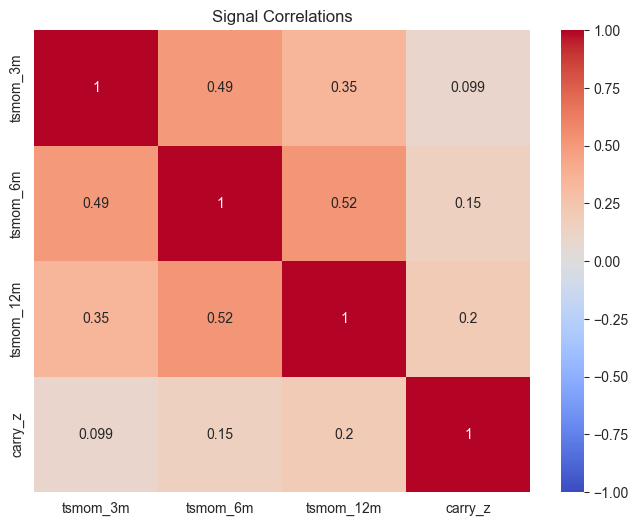

In [9]:
# 1. Signal Correlations
signal_cols = [f'tsmom_{k}m' for k in lookbacks] + ['carry_z']
corr = df_signals[signal_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Signal Correlations')
plt.show()

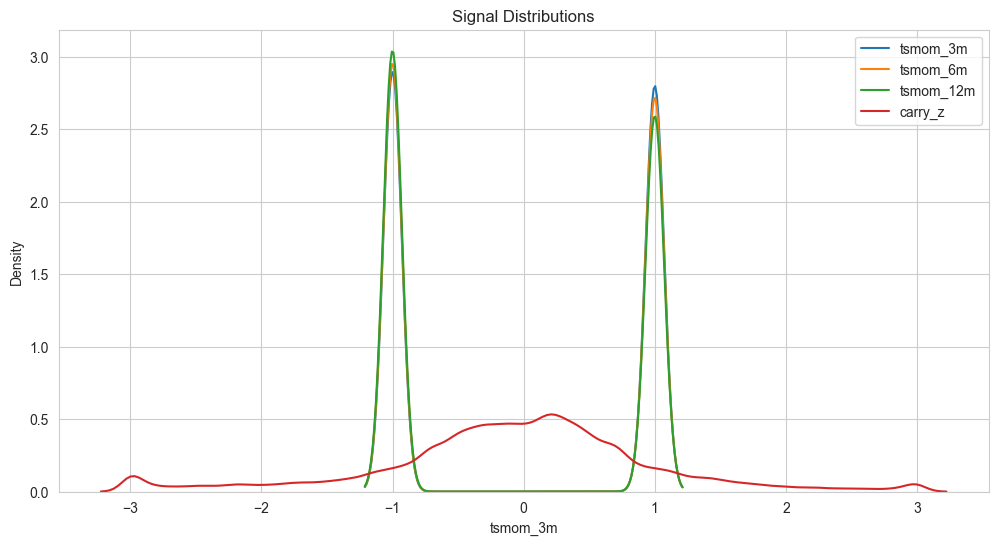

In [10]:
# 2. Signal Distribution
plt.figure(figsize=(12, 6))
for col in signal_cols:
    sns.kdeplot(df_signals[col].dropna(), label=col)
plt.title('Signal Distributions')
plt.legend()
plt.show()

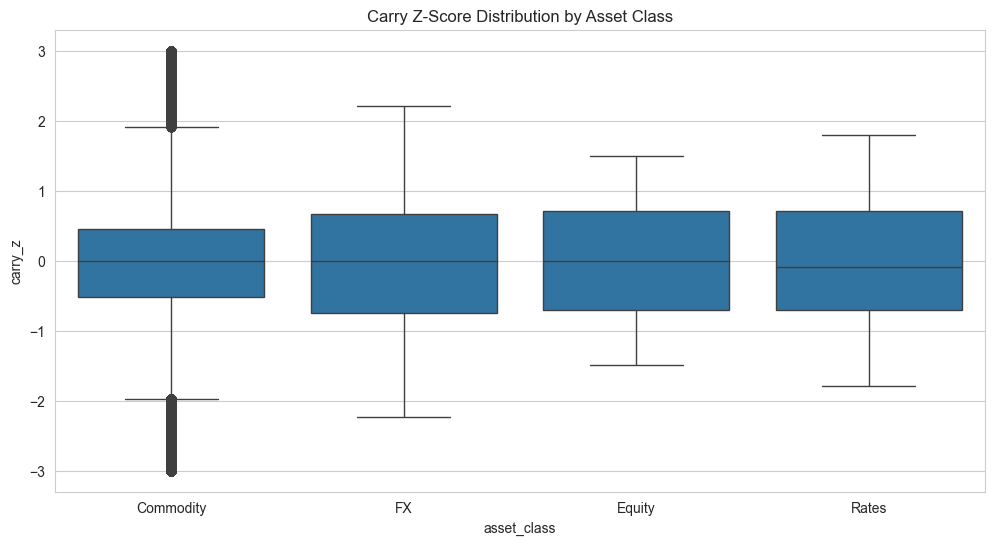

Stats by Asset Class:


,count,mean,std,min,25%,50%,75%,max
asset_class,,,,,,,,
Commodity,463513.0,-0.081862,1.101062,-3.000000,-0.519248,-0.010406,0.454109,3.000000
Equity,23316.0,0.020558,0.789249,-1.493184,-0.707107,-0.001171,0.707107,1.499148
FX,74458.0,-0.034828,0.893376,-2.240075,-0.753126,0.000887,0.669334,2.215279
Rates,19661.0,0.013230,0.866749,-1.788675,-0.707107,-0.093267,0.707107,1.787171


In [11]:
# 3. Carry Z-Score by Asset Class (Sanity Check)
# Should be roughly mean 0, std 1 per asset class
plt.figure(figsize=(12, 6))
sns.boxplot(x='asset_class', y='carry_z', data=df_signals)
plt.title('Carry Z-Score Distribution by Asset Class')
plt.show()

print("Stats by Asset Class:")
display(df_signals.groupby('asset_class')['carry_z'].describe())